# State of the Art + ? Analytical Method

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils.utils import *
from scipy.optimize import curve_fit
from utils.download_utils import download_and_extract_zip


count_to_deg = 360/(2**24)
radian_to_deg = 180/np.pi
radian_to_deg = 180/np.pi
axis = 3
gear_ratio = 101
offset_m = -82960 
offset_l = 1145843

Analytical approach of finding the external joint torque focuses on modeling and computing all the known torques acting at the joint such as friction, dynamics, position based torque (footprint).After compensatig for the known torques, the hypothesis is that the residual will be the external torque. Inorder to simplify the study, only Axis 3 was studied , the other joint angles were kept locked at 0°. 

## 3.1.1 Data Colleciton

To simplify the dynamics acting on the joint under study (Axis 3), the robot was mounted in a 90° orientation so that the axis of the joint is paralell to gravity, which allows the axis to be rotated wihtout gravity affetcing the dynamics. #insert figure for reference. 

In [2]:
#run this cell to download the data
download_and_extract_zip("analytical_dataset","./utils/config.json")

  0%|          | 0/170923 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


In [3]:
import os
import pandas as pd

# Define the base directories
base_dir = '/mnt/data/analytical/lara8_90deg_0load/'
output_dir = '/mnt/data/analytical/data/'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define the columns you want to read
columns_to_read = ["encoder_motorinc_3" , "encoder_loadinc_3", "joint_velocity_3","joint_torque_current_3","target_joint_torque_3","joint_angles_3",
                   "fts_reading_1","fts_reading_2","fts_reading_3","fts_reading_4","fts_reading_5","fts_reading_6"] # replace with your actual column names

# Get the list of subdirectories
subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop over each subdirectory
for subdir in subdirs:
    # Define the paths to the positive and negative CSV files
    pos_file = os.path.join(base_dir, subdir, 'positive.csv')
    neg_file = os.path.join(base_dir, subdir, 'negative.csv')

    # Check if both files exist
    if os.path.exists(pos_file) and os.path.exists(neg_file):
        try:
            # Read the CSV files with specified columns
            pos_df = pd.read_csv(pos_file, encoding='ISO-8859-1', usecols=columns_to_read)
            neg_df = pd.read_csv(neg_file, encoding='ISO-8859-1', usecols=columns_to_read)

            # Concatenate the dataframes
            combined_df = pd.concat([pos_df, neg_df])

            # Save the combined dataframe to a new CSV file in the data folder
            combined_df.to_csv(os.path.join(output_dir, f'{subdir}.csv'), index=False)
        except pd.errors.ParserError as e:
            print(f"Error parsing files in directory {subdir}: {e}")
        except Exception as e:
            print(f"Unexpected error with files in directory {subdir}: {e}")



In [25]:
# Define the directory containing the combined CSV files
directory = '/mnt/data/analytical/data/'

# List all CSV files in the directory that end with '.csv'
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Initialize an empty dictionary to store the dataframes
data = {}

# Loop over each CSV file
for file in csv_files:
    try:
        # Read each CSV file into a dataframe
        df = pd.read_csv(os.path.join(directory, file))

        # Store the dataframe in the dictionary
        # Use the filename (without .csv) as the key
        key = os.path.splitext(file)[0]
        data[key] = df
        #print(f"Loaded {key}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

In [26]:
min_length = None
min_length_key = None
for key in data:
    df = data[key]
    length = len(df)
    if min_length is None or length < min_length:
        min_length = length
        min_length_key = key
print("The smallest dataframe is ", key, " and has ", min_length, " rows.")

The smallest dataframe is  0.97  and has  2791  rows.


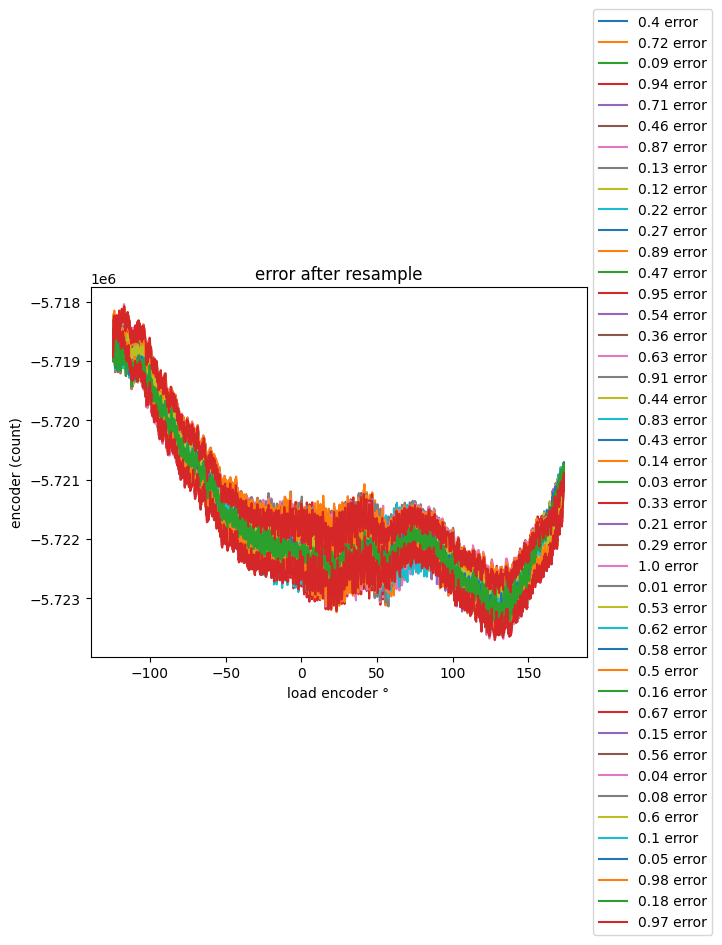

In [27]:
#resample to create equal length dataframes
for key in data:
    data[key]= resample2(data[key],min_length)

for key in data:
    plt.plot(data[key].encoder_loadinc_3*count_to_deg,data[key].encoder_motorinc_3/gear_ratio - data[key].encoder_loadinc_3,label = key +' error')
plt.ylabel('encoder (count)')
plt.xlabel('load encoder °')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("error after resample")
plt.show()

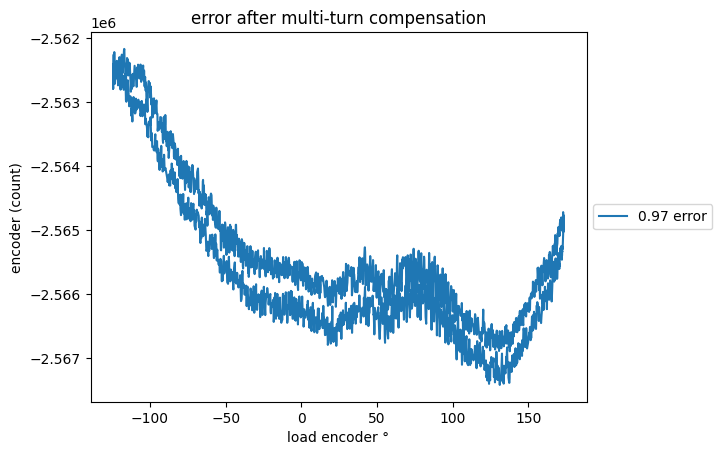

In [28]:
#multiturn compensation
for key in data:
    data[key]= multiturn_compensation(data[key],offset_m,offset_l)


#for key in data:
#    plt.plot(data[key].encoder_loadinc_3*count_to_deg,data[key].encoder_motorinc_3/gear_ratio - data[key].encoder_loadinc_3,label = key +' error')
plt.plot(data["0.71"].encoder_loadinc_3*count_to_deg,data["0.71"].encoder_motorinc_3/gear_ratio - data["0.71"].encoder_loadinc_3,label = key +' error')
plt.ylabel('encoder (count)')
plt.xlabel('load encoder °')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("error after multi-turn compensation")
plt.show()


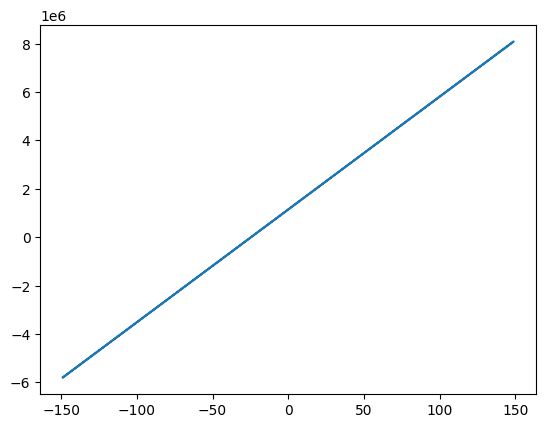

In [34]:
key = "0.4"
plt.plot(data[key].joint_angles_3*radian_to_deg,data[key].encoder_loadinc_3,label = key +' error')

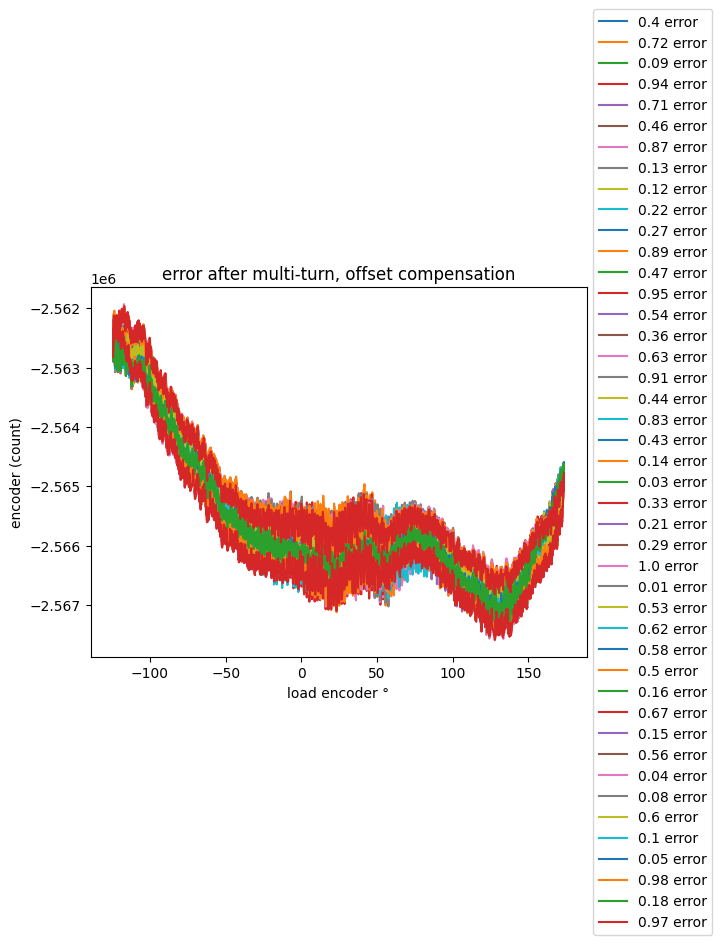

In [36]:
#offset compensation
#for key in data:
    #data[key]= offset_compensation(data[key],offset_m,offset_l)
for key in data:
    plt.plot(data[key].encoder_loadinc_3*count_to_deg,data[key].encoder_motorinc_3/gear_ratio - data[key].encoder_loadinc_3,label = key +' error')
plt.ylabel('encoder (count)')
plt.xlabel('load encoder °')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("error after multi-turn, offset compensation")
plt.show()

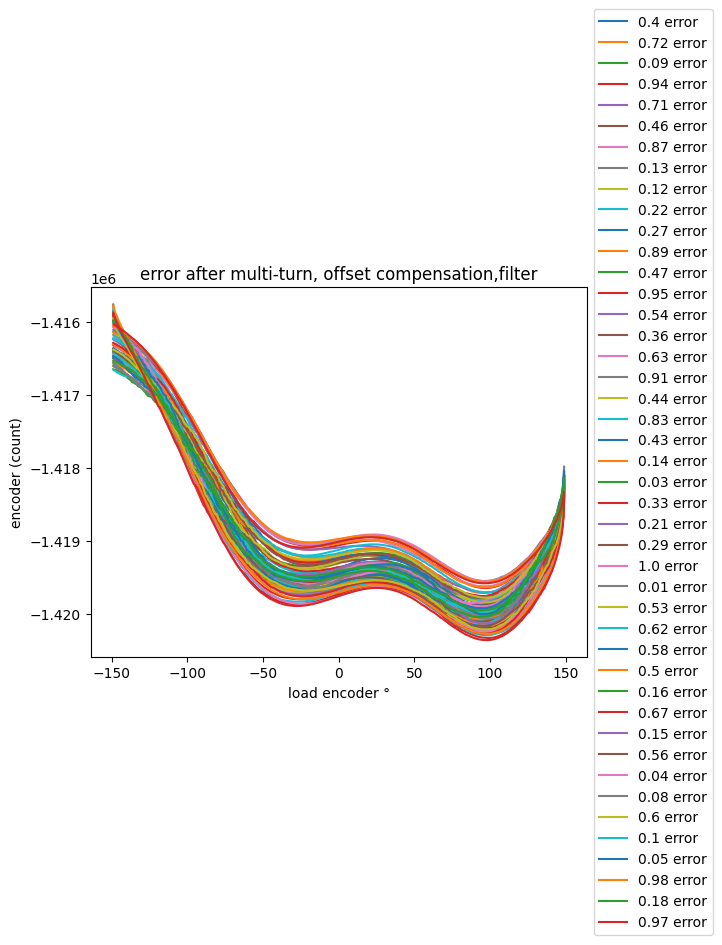

In [9]:
#apply low pass filter
for key in data:
    data[key]= filter(data[key],1)
for key in data:
    plt.plot(data[key].encoder_loadinc_3*count_to_deg,data[key].filtered_motor_enc/gear_ratio - data[key].filtered_load_enc,label = key +' error')
plt.ylabel('encoder (count)')
plt.xlabel('load encoder °')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("error after multi-turn, offset compensation,filter")
plt.show()

RMS value residual error: 0.005857905314221413
RMS value actual error: 30.28233318135123
The Model has reduced the error


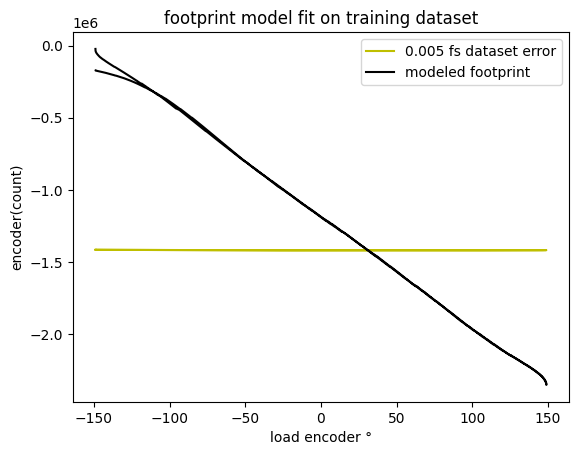

In [10]:
#learn foot print from the slowest data 
footprint_coeff = model_footprint(data["0.97"])
np.save("footprint_coeff.npy",footprint_coeff)

for key in data:
    data[key]['modeled_footprint'] = data[key].apply(lambda row: footprint_error(footprint_coeff,row["filtered_motor_enc"], row["filtered_load_enc"]), axis=1)


plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg, (data["0.97"].filtered_motor_enc/gear_ratio - data["0.97"].filtered_load_enc) ,'y',label = '0.005 fs dataset error')
plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg,data["0.97"].modeled_footprint/count_to_deg,'black',label = 'modeled footprint')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on training dataset")
plt.show()
plt.close()



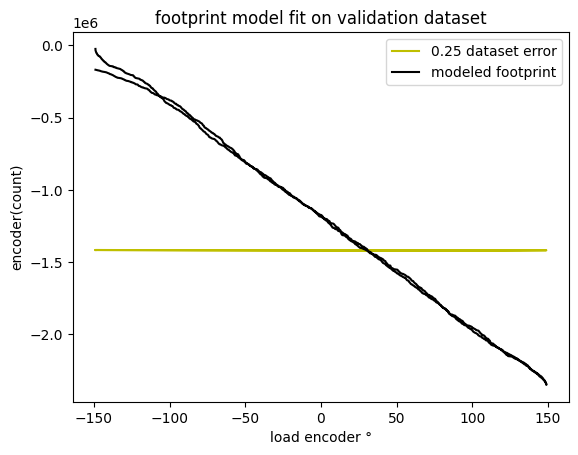

In [11]:
plt.plot(data["0.27"].encoder_loadinc_3*count_to_deg, (data["0.27"].filtered_motor_enc/gear_ratio - data["0.27"].filtered_load_enc) ,'y',label = '0.25 dataset error')
plt.plot(data["0.27"].encoder_loadinc_3*count_to_deg,data["0.27"].modeled_footprint/count_to_deg,'black',label = 'modeled footprint')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on validation dataset")
plt.show()
plt.close()


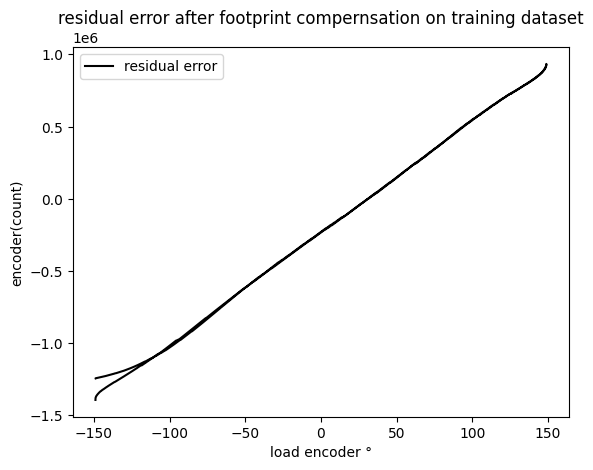

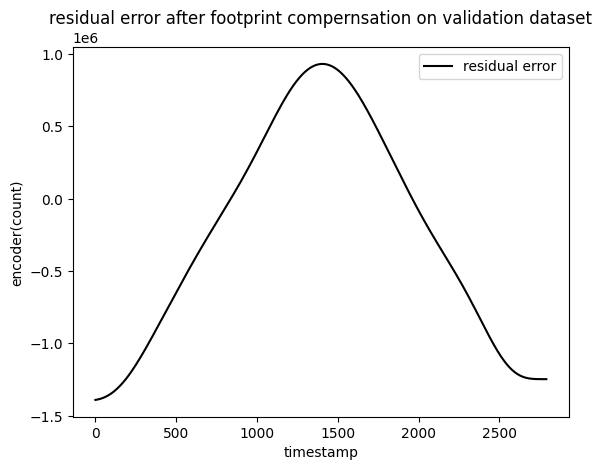

In [12]:
#calculate residuals by compensating for footprint
for key in data:
    data[key]['residual_error'] = data[key].filtered_motor_enc/gear_ratio - data[key].filtered_load_enc - data[key].modeled_footprint/count_to_deg #count

plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg,data["0.97"].residual_error,'black',label = 'residual error')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("residual error after footprint compernsation on training dataset")
plt.show()
plt.close()

plt.plot(data["0.27"].residual_error,'black',label = 'residual error')
plt.ylabel('encoder(count)')
plt.xlabel('timestamp')
plt.legend()
plt.title("residual error after footprint compernsation on validation dataset")
plt.show()
plt.close()

In [13]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'utils')))
print(os.path.abspath(os.path.join(os.getcwd(), 'utils')))

/home/jovyan/work/utils


In [14]:
#compensat for dynamics(remove friction component in dynamic)
for key in data:
    data[key]['inverse_dynamics'] = data[key].apply(lambda row:row["target_joint_torque_3"] - controller_friction_estimate(row["joint_velocity_3"]), axis=1)
    data[key]["dynamic_compensation"] = data[key].apply(lambda row: torque_to_encoder_error(row["inverse_dynamics"]), axis=1)
    data[key]["residual_error2"] = data[key].residual_error - data[key].dynamic_compensation

In [15]:
#append all dataframes
dfs = data["0.97"].iloc[:0,:].copy()
for key in data:
    dfs=pandas.concat([dfs,data[key]])

#model friction
parameters,_ = curve_fit(friction_model,dfs.joint_velocity_3*radian_to_deg,dfs.residual_error2)
#save variables to file
np.save("friction_coeff.npy",parameters)

y = np.arange (-90, 90, 0.01)
x = friction_model(y,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5])
plt.plot(y,x,'g',label='friction model')
plt.legend()
plt.xlabel("joint velocity degrees/s")
plt.ylabel("encoder difference (count)")
plt.title("friction model")
plt.legend()
plt.show()
plt.close()


ValueError: array must not contain infs or NaNs

In [ ]:


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dfs.joint_velocity_3*radian_to_deg,'m',label = " joint velocity")
ax2.plot( dfs.residual_error,'c',label = "residul error")
dfs['modeled_friction'] = dfs.apply(lambda row: friction_model(row["joint_velocity_3"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
ax2.plot(dfs.modeled_friction,'black',label='friction model')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('joint velocity', color='m')
ax2.set_ylabel('encoder difference (count)', color='c')
ax2.legend()
plt.title("Joint velocity ,residual error, friction model")
plt.show()
plt.close()

In [ ]:
#comepnesate for friction
for key in data:
    data[key]['modeled_friction'] = data[key].apply(lambda row: friction_model(row["filtered_joint_velocity"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
    data[key]["residual_error3"] = data[key].residual_error2 - data[key].modeled_friction
    

plt.plot(data["0.27"].encoder_loadinc_3*count_to_deg, data["0.27"].residual_error3,'black',label = '0.27 residual error')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("error after compensating for multi-turn, offset, \n footprint,dynamics and friction ")
plt.show()
plt.close()


